In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from simulation.analyse import get_win_probabilities, get_simulations
from features.data_provider import get_whole_dataset
from models.outcome_model import get_model
from simulation.predictor import MaxProbabilityPredictor
from simulation.simulation import run_simulation, run_actual_tournament_simulation
from db.simulation_table import store_simulation_results, delete_all

In [10]:
def plot_bank_and_bets(banks, bets, results):
    colors = {0: 'r', 1: 'g'}
    fig, ax = plt.subplots(figsize=(12, 12))
    index = np.arange(len(bets))
    ax.bar(index, bets, color=[colors[i] for i in results]) 
    ax.plot(banks)

In [2]:
X, y = get_whole_dataset("home_win", filter_start="2014-06-12")
model = get_model(X=X, y=y)
predictor = MaxProbabilityPredictor(model)

In [3]:
match_template = pd.read_csv('data/original/wc_2014_real.csv')
run_actual_tournament_simulation(match_template, predictor)
store_simulation_results("data/simulations/tmp/single_simulation_wc2014.csv")
delete_all()

In [4]:
simulation = pd.read_csv('data/simulations/tmp/single_simulation_wc2014.csv')
simulation

,Unnamed: 0,id,match_id,date,home_team,away_team,home_score,away_score,outcome,home_win_prob,draw_prob,away_win_prob
0,0,1,0,2014-06-12,Brazil,Croatia,3,1,1,0.535042,0.248374,0.216584
1,1,2,1,2014-06-13,Chile,Australia,3,1,1,0.582452,0.220345,0.197202
2,2,3,2,2014-06-13,Mexico,Cameroon,1,0,1,0.432733,0.288016,0.279251
3,3,4,3,2014-06-13,Spain,Netherlands,1,5,1,0.478421,0.267516,0.254062
4,4,5,4,2014-06-14,Colombia,Greece,3,0,1,0.488257,0.269269,0.242474
5,5,6,5,2014-06-14,England,Italy,1,2,-1,0.325749,0.273981,0.400270
6,6,7,6,2014-06-14,Ivory Coast,Japan,2,1,-1,0.361187,0.271868,0.366945
7,7,8,7,2014-06-14,Uruguay,Costa Rica,1,3,1,0.550466,0.244448,0.205086
8,8,9,8,2014-06-15,Argentina,Bosnia and Herzegovina,2,1,1,0.580006,0.232178,0.187816
9,9,10,9,2014-06-15,France,Honduras,3,0,1,0.722449,0.169078,0.108473


In [5]:
simulation["true_outcome"] = np.sign(simulation["home_score"] - simulation["away_score"])


In [6]:
match_bets = pd.read_csv('data/original/wc_2014_bets.csv')

1.1590625
74.18


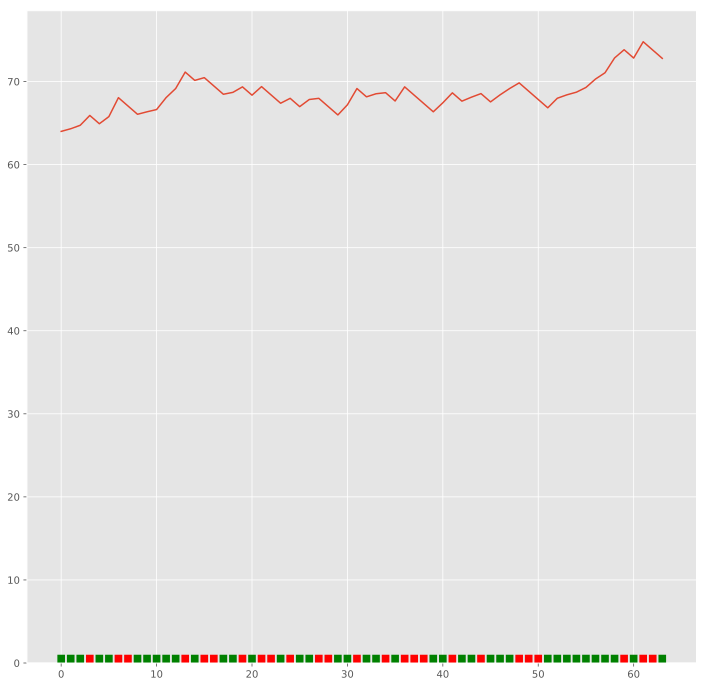

In [11]:
y_pred = simulation["outcome"].values
y_true = simulation["true_outcome"].values
odds = match_bets[["1", "X", "2"]].values

bets = []
banks = []
results = []

bet_size = 1
initial_capital = 64
bank = initial_capital
for i in range(len(y_true)):
    if bank <= bet_size:
        print("Bank empty")
        break
        
    banks.append(bank)
    bets.append(bet_size)
    
    bank -= bet_size
    predicted_outcome = y_pred[i]
    if y_true[i] == predicted_outcome:
        if predicted_outcome == 1:
            odd = odds[i, 0]
        elif predicted_outcome == 0:
            odd = odds[i, 1]
        else:
            odd = odds[i, 2]
        bank += odd * bet_size
        results.append(1)
    else:
        results.append(0)
print(bank/initial_capital)
print(bank)

plot_bank_and_bets(banks, bets, results)

2.49879408918
159.922821708


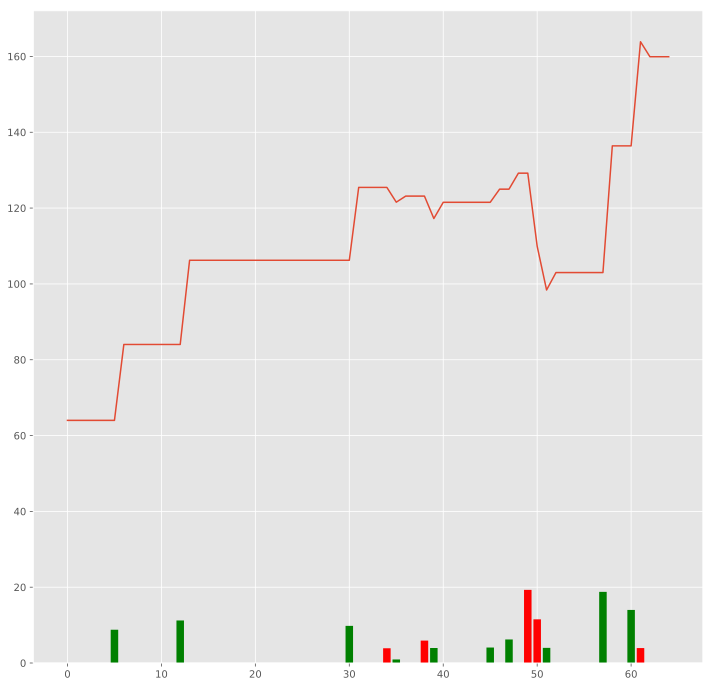

In [12]:
y_pred = simulation["outcome"].values
y_true = simulation["true_outcome"].values
odds = match_bets[["1", "X", "2"]].values
probabilities = simulation[["home_win_prob", "draw_prob", "away_win_prob"]].values

teams = simulation[["home_team", "away_team"]].values

initial_capital = 64
bank = initial_capital

bets = []
banks = []
results = []
for i in range(len(y_true)):
    predicted_outcome = y_pred[i]
    if predicted_outcome == 1:
        odd = odds[i, 0]
        p = probabilities[i, 0]
    elif predicted_outcome == 0:
        odd = odds[i, 1]
        p = probabilities[i, 1]
    else:
        odd = odds[i, 2]
        p = probabilities[i, 2]
    
    b = odd-1
    q = 1-p
    f = max((b*p - q)/b, 0)
    bet_size = bank * f
    
    banks.append(bank)
    bets.append(bet_size)
    
    bank -= bet_size
   
    if y_true[i] == predicted_outcome:
        win = odd * bet_size
        bank += win
        results.append(1)
    else:
        results.append(0)
        


banks.append(bank)
bets.append(bet_size)

print(bank/initial_capital)
print(bank)
plot_bank_and_bets(banks, bets, results)